<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: Мария Мансурова, аналитик-разработчик в команде Яндекс.Метрики 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [98]:
df.shape

(383, 7)

In [99]:
df.date = pd.to_datetime(df.date)

In [100]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [101]:
from fbprophet import Prophet

In [102]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [103]:
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [104]:
prt = Prophet(yearly_seasonality=False, daily_seasonality=False)
prt.fit(train_df)

/Users/ilchenkoslava/anaconda3/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [105]:
future = prt.make_future_dataframe(periods=predictions)

In [106]:
%%time
forecast = prt.predict(future)

CPU times: user 2.76 s, sys: 19.4 ms, total: 2.78 s
Wall time: 2.78 s


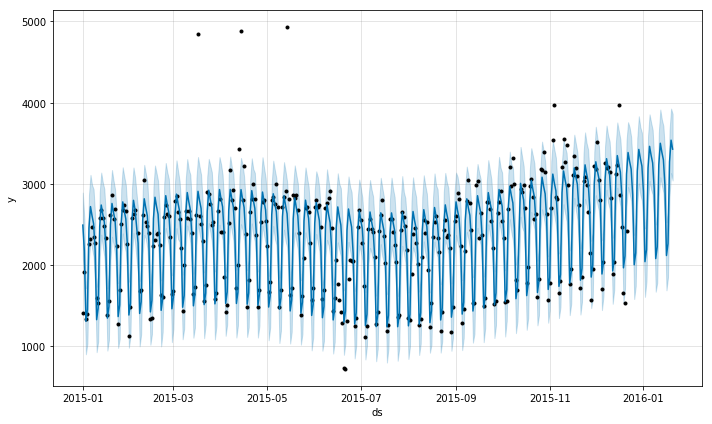

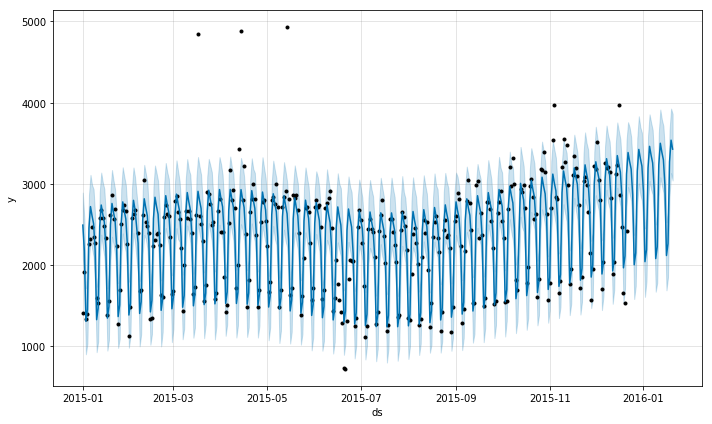

In [107]:
prt.plot(forecast)

In [108]:
int(forecast[forecast['ds'] == '2016-01-20']['yhat'].values[0])

3428

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

***3428***.

Оценим качество предсказания по последним 30 точкам.

In [109]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE = ', mean_absolute_percentage_error(df['y'][-30:], forecast['yhat'][-30:]))
print('MAE = ', mean_absolute_error(df['y'][-30:], forecast['yhat'][-30:]))

MAPE =  34.5771472755951
MAE =  601.3806679529374


**Вопрос 2**: Какое получилось MAPE?

*** 34.58 ***

**Вопрос 3**: Какое получилось MAE?

*** 601.38 ***

## Предсказываем с помощью ARIMA

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

Критерий Дики-Фуллера: p=0.107392


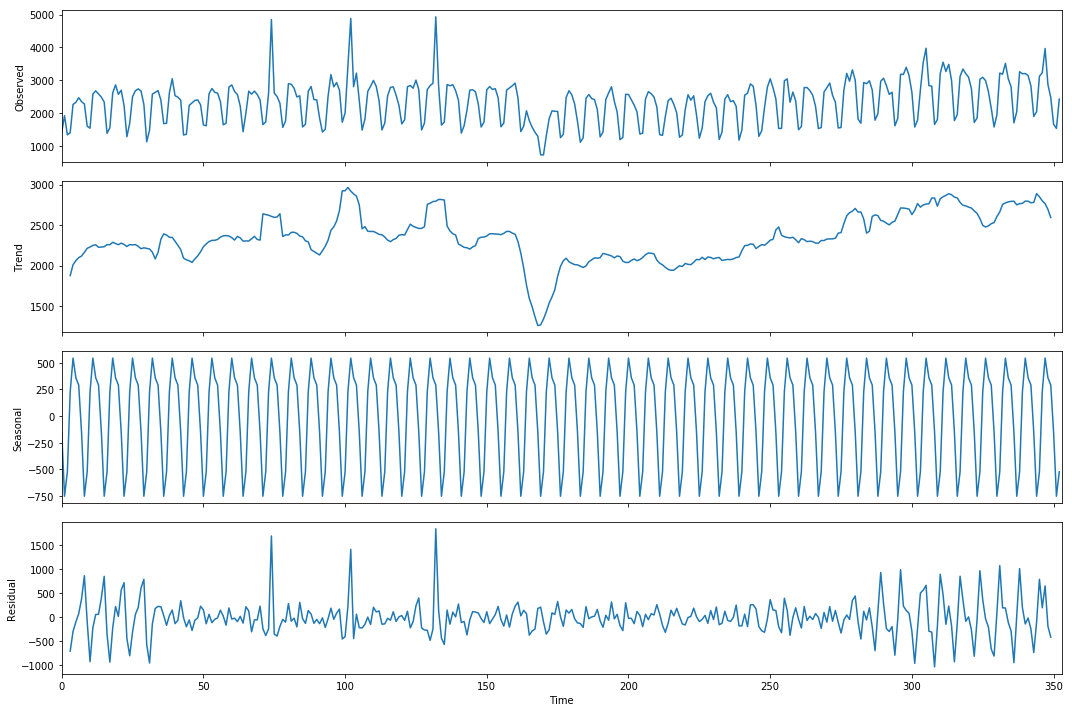

In [111]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [112]:
## ВАШ КОД для построения модели ##